

<a target="_blank" href="https://colab.research.google.com/github/pywavelet/pywavelet/blob/main/docs/runtime.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Runtime Comparisons

In [ ]:
import time

! pip install pywavelet -q

[16:07:12] INFO     Using NumPy backend                                                               ]8;id=521687;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/backend.py\backend.py]8;;\:]8;id=776845;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/backend.py#79\79]8;;\

/Users/avaj0001/miniforge3/envs/pywavelet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:2025-04-01 16:07:15,339:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'


[16:07:15] INFO     Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no     ]8;id=325124;file:///Users/avaj0001/miniforge3/envs/pywavelet/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=623083;file:///Users/avaj0001/miniforge3/envs/pywavelet/lib/python3.10/site-packages/jax/_src/xla_bridge.py#927\927]8;;\
                    attribute 'GpuAllocatorConfig'                                                                 

INFO:2025-04-01 16:07:15,347:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/avaj0001/miniforge3/envs/pywavelet/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)


           INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so:       ]8;id=222212;file:///Users/avaj0001/miniforge3/envs/pywavelet/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=646794;file:///Users/avaj0001/miniforge3/envs/pywavelet/lib/python3.10/site-packages/jax/_src/xla_bridge.py#927\927]8;;\
                    dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file),                                  
                    '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file),                                
                    '/Users/avaj0001/miniforge3/envs/pywavelet/bin/../lib/libtpu.so' (no such                      
                    file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so'                     
                    (no such file), '/usr/local/lib/libtpu.so' (no such file),                                     
                    '/usr/lib/libtpu.so' (no such file, not in dyld cache)                                         

Running: 100%|██████████| 6/6 [00:07<00:00,  1.25s/it, ND=2**14]


[16:07:22] WARNING  JAX SUBPACKAGE NOT FULLY TESTED                                                   ]8;id=119815;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py\__init__.py]8;;\:]8;id=632460;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py#5\5]8;;\

           INFO     Jax running on cpu [32bit precision].                                            ]8;id=477238;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py\__init__.py]8;;\:]8;id=970633;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py#21\21]8;;\

           WARNING  Jax is not running in 64bit precision. To change, use                            ]8;id=495625;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py\__init__.py]8;;\:]8;id=228563;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py#23\23]8;;\
                    jax.config.update('jax_enable_x64', True).                                                     

Running: 100%|██████████| 6/6 [00:06<00:00,  1.16s/it, ND=2**14]


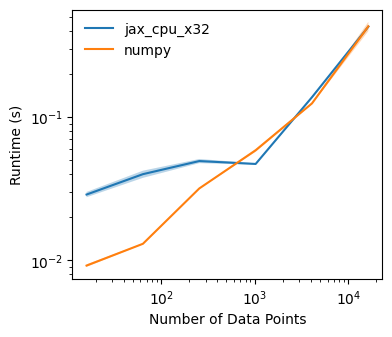

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas as pd
import jax
import json
import os

from pywavelet.backend import cuda_available
from tqdm.auto import tqdm
from pywavelet.types import FrequencySeries
from pywavelet.transforms.phi_computer import phitilde_vec_norm
from timeit import repeat as timing_repeat
import matplotlib.pyplot as plt
from typing import Tuple
import glob

jax.config.update("jax_enable_x64", False)
JAX_DEVICE = jax.default_backend()
JAX_PRECISION = "x64" if jax.config.jax_enable_x64 else "x32"

if cuda_available:
    import cupy as cp

min_pow2 = 2
max_pow2 = 14
NF = [2**i for i in range(min_pow2, max_pow2)]
NREP = 5


def generate_freq_domain_signal(
    ND, f0=20.0, dt=0.0125, A=2
) -> FrequencySeries:
    """
    Generates a frequency domain signal.

    Parameters:
    ND (int): Number of data points.
    f0 (float): Frequency of the signal. Default is 20.0.
    dt (float): Time step. Default is 0.0125.
    A (float): Amplitude of the signal. Default is 2.

    Returns:
    FrequencySeries: The generated frequency domain signal.
    """
    ts = np.arange(0, ND) * dt
    y = A * np.sin(2 * np.pi * f0 * ts)
    yf = FrequencySeries(y, ts)
    return yf


def generate_func_args(ND: int, label="numpy") -> Tuple:
    Nf = Nt = int(np.sqrt(ND))
    yf = generate_freq_domain_signal(ND).data
    phif = phitilde_vec_norm(Nf, Nt, d=4.0)
    if "jax" in label:
        yf = jnp.array(yf)
        phif = jnp.array(phif)
    if "cupy" in label and cuda_available:
        yf = cp.array(yf)
        phif = cp.array(phif)
    return yf, Nf, Nt, phif


def collect_runtime(func, func_args) -> Tuple[float, float]:
    warm_time = 0
    for i in range(5):
        t0 = time.process_time()
        func(*func_args)  # Warm up run
        warm_time = time.process_time() - t0

    if warm_time < 0.001:
        number = 1000
    elif warm_time < 0.1:
        number = 10
    else:
        number = 1
    # see https://stackoverflow.com/questions/48258008/n-and-r-arguments-to-ipythons-timeit-magic/59543135#59543135

    times = timing_repeat(lambda: func(*func_args), number=number, repeat=NREP)
    return np.median(times), np.std(times)


def collect_runtimes(func, label, NF_values) -> np.ndarray:
    results = np.zeros((len(NF_values), 3))
    bar = tqdm(NF_values, desc="Running")
    for i, Nf in enumerate(bar):
        ND = Nf * Nf
        bar.set_postfix(ND=f"2**{int(np.log2(ND))}")
        func_args = generate_func_args(ND, label)
        try:
            _times = collect_runtime(func, func_args)
        except Exception as e:
            print(f"Error processing ND={ND}: {e}")
            _times = (np.nan, np.nan)
        results[i] = np.array([ND, *_times])

    runtimes = pd.DataFrame(results, columns=["ND", "median", "std"])
    runtimes.to_csv(f"runtime_{label}.csv", index=False)

    return runtimes


def save_jax_runtimes():
    from pywavelet.transforms.jax.forward.from_freq import (
        transform_wavelet_freq_helper as jax_transform,
    )

    jax_label = f"jax_{JAX_DEVICE}_{JAX_PRECISION}"
    collect_runtimes(jax_transform, jax_label, NF)


def save_cupy_runtimes():
    from pywavelet.transforms.cupy.forward.from_freq import (
        transform_wavelet_freq_helper as cp_transform,
    )

    collect_runtimes(cp_transform, "cupy", NF)


def save_numpy_runtimes():
    from pywavelet.transforms.numpy.forward.from_freq import (
        transform_wavelet_freq_helper as np_transform,
    )

    collect_runtimes(np_transform, "numpy", NF)


def cache_all_runtimes(cache_fn: str = "runtimes.json"):
    data = {}
    for f in glob.glob("runtime_*.csv"):
        df = pd.read_csv(f)
        label = f.split("runtime_")[1].split(".")[0]
        data[label] = df.to_dict(orient="records")

    # load any existing data
    if os.path.exists(cache_fn):
        with open(cache_fn, "r") as f:
            existing_data = json.load(f)
            data.update(existing_data)

    # save to json
    with open(cache_fn, "w") as f:
        json.dump(data, f, indent=4)


def plot_all_runtimes(cache_fn: str = "runtimes.json"):
    fig, ax = plt.subplots(figsize=(4, 3.5))

    with open(cache_fn, "r") as f:
        data = json.load(f)
        for label, runtimes in data.items():
            runtimes = pd.DataFrame(runtimes)
            plot(runtimes, ax=ax, label=label)
    ax.legend(frameon=False)
    return fig, ax


def plot(
    runtimes: pd.DataFrame, ax=None, **kwgs
) -> Tuple[plt.Figure, plt.Axes]:
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3.5))
    fig = ax.figure

    runtimes = runtimes.dropna()
    runtimes = runtimes.sort_values(by="ND")

    nds = runtimes["ND"].values
    times, stds = runtimes["median"], runtimes["std"]
    ax.plot(nds, times, **kwgs)
    kwgs["label"] = None
    ax.fill_between(
        nds,
        np.array(times) - np.array(stds),
        np.array(times) + np.array(stds),
        alpha=0.3,
        **kwgs,
    )

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Number of Data Points")
    ax.set_ylabel("Runtime (s)")
    return fig, ax


save_numpy_runtimes()
save_jax_runtimes()
cache_all_runtimes()
fig, ax = plot_all_runtimes()
fig.savefig("runtimes.png", bbox_inches="tight")